# NYC Yellow Taxi Tips Prediction

This example is based on the 2019 [NYC Yellow Cab trip record data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) made available by the NYC Taxi and Limousine Commission (TLC). This dataset has been widely used on Kaggle and elsewhere. Todd Schneider has written [a nice in-depth analysis of the dataset](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/).

After exploring the data, we will use a regression model to predict taxi tips.

<div class="alert alert-block alert-info">
<b>Note:</b>

In this notebook, we will run the code using Bodo. This means that the data will be distributed in chunks across processes. [Bodo's documentation](https://docs.bodo.ai/2022.2/bodo_parallelism/bodo_parallelism_basics/) provides more information about the parallel execution model.

If you want to run the example using Pandas only (without Bodo):

1. Comment out lines with the magic expression (`%%px`) and Bodo JIT decorator (`@bodo.jit`) from all the code cells.
2. Then, re-run cells from the beginning.

Consult the [IPyParallel documentation](https://ipyparallel.readthedocs.io/en/latest/) for more information about setting up a local cluster.
</div>

## Start an IPyParallel cluster (skip if running on Bodo's Platform)



In [1]:
import os
if os.environ.get("BODO_PLATFORM_WORKSPACE_UUID",'NA') == 'NA':
    import ipyparallel as ipp
    import psutil; n = min(psutil.cpu_count(logical=False), 8)
    rc = ipp.Cluster(engines='mpi', n=n).start_and_connect_sync(activate=True)

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.11engine/s]


## Import all packages

These are the main packages we are going to work with:
* [Bodo](https://docs.bodo.ai/2022.2/) to parallelize Python code automatically;
* [IPyParallel](https://ipyparallel.readthedocs.io/en/latest/) for setting up a local cluster;
* [s3fs](https://s3fs.readthedocs.io/en/latest/#) to download data from AWS S3 buckets;
* [Pandas](https://pandas.pydata.org) to manipulate tabular data structures;
* [Seaborn](https://seaborn.pydata.org/index.html) and [Matplotlib](https://matplotlib.org) for data visualization; and
* [Scikit-Learn](https://scikit-learn.org/stable/) to build and evaluate regression models.

## Dataset

We use the data from the year 2019 . We can fetch the data directly from the [NYC Taxi & Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page); alternatively, we can get it from one of Bodo's AWS S3 open buckets (no AWS credentials required).

In the following cell, we load the dataset directly from AWS using the URI `s3://bodo-examples-data/nyc-taxi/yellow_tripdata_2019.csv`.

Bodo's platform doesn't have seaborn library installed by default. Since we use it in this example, let's install it first. To install a library on all the nodes using the notebook, you can use `%ppip install <lib>` as follows.

In [ ]:
%ppip install seaborn

In [2]:
%%px
import bodo

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25tasks/s]


In [5]:
%%px

@bodo.jit(cache=True)
def load_data():
    taxi = pd.read_csv(
        "s3://bodo-examples-data/nyc-taxi/yellow_tripdata_2019.csv",
        parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
    )
    print(taxi.head(1))
    print(taxi.shape)
    return taxi

taxi = load_data()

%px:   0%|                                                                                                                                                                                                    | 0/4 [00:06<?, ?tasks/s]

[stdout:0]    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2019-01-01 00:46:40   2019-01-01 00:53:20                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.5           1                  N           151           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          7.0    0.5      0.5        1.65           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3          9.95                   NaN  
(7667792, 18)


%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.62s/tasks]


In [10]:
%%px
taxi.shape

Out[0:8]: (1916948, 18)

Out[1:8]: (1916948, 18)

Out[2:8]: (1916948, 18)

Out[3:8]: (1916948, 18)

By default, the data is distributed to all available engines; that is, the rows of the DataFrame `taxi` are split into four partitions and sent to each of the cores. This allows embarrassingly parallel algorithms—like computing sums—to scale with the data and resources at hand.

## Exploratory analysis

The dataset consist of 18 columns; see the [TLS documentation](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for more details on the meanings of each field. Our goal here is to predict the tip amount of a ride using some features.

Before doing anything, it might be interesting for us to look at the raw data to see if we can extract patterns.

In [11]:
%%px

@bodo.jit(cache=True)
def data_preparation(taxi):

    # remove fare=0 and only keep credit card trips
    taxi_filtered = taxi[
        (taxi.fare_amount > 0) & (taxi.payment_type == 1) & (taxi.trip_distance > 0.01)
    ].copy()
    
    # the quantity of interest
    taxi_filtered['tip_fraction'] = taxi_filtered.tip_amount / taxi_filtered.fare_amount
    
    # tpep_pickup_datetime
    taxi_filtered['pickup_weekday'] = taxi_filtered.tpep_pickup_datetime.dt.weekday
    taxi_filtered['pickup_week'] = taxi_filtered.tpep_pickup_datetime.dt.isocalendar().week
    taxi_filtered['pickup_hour'] = taxi_filtered.tpep_pickup_datetime.dt.hour
    taxi_filtered['pickup_week_hour'] = (taxi_filtered.pickup_weekday * 24) + taxi_filtered.pickup_hour
    taxi_filtered['pickup_minute'] = taxi_filtered.tpep_pickup_datetime.dt.minute
    
    # tpep_dropoff_datetime
    taxi_filtered['dropoff_weekday'] = taxi_filtered.tpep_dropoff_datetime.dt.weekday
    taxi_filtered['dropoff_week'] = taxi_filtered.tpep_dropoff_datetime.dt.isocalendar().week
    taxi_filtered['dropoff_hour'] = taxi_filtered.tpep_dropoff_datetime.dt.hour
    taxi_filtered['dropoff_week_hour'] = (taxi_filtered.dropoff_weekday * 24) + taxi_filtered.dropoff_hour
    taxi_filtered['dropoff_minute'] = taxi_filtered.tpep_dropoff_datetime.dt.minute
    
    return taxi_filtered

taxi_filtered = data_preparation(taxi)

%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.39s/tasks]


There are a few preprocessing steps we can make based on insights available from examining the dataset. The data sheet states "cash tips are not included," so we'll look at credit card transactions exclusively. Other fields are unclear and show rows have some suspicious entries (e.g., a trip of lenght 0 miles with no charge but a tip of $50). To mitigate the presence of outliers and data pollution, we modify the data beforehand by: 

1. removing records with a price of $0.00;
2. removing records with a trip distance of < 0.01 miles;
3. keeping only records with credit card transactions;
4. computing `tip_fraction` only for these relevant records; and
5. processing the date into discrete values (day of the week, day of the month, etc.).

First, let's have a look at both `tip_fraction` and `fare_amount` distributions. The dataset is randomly subsampled to facilitate computations outside Bodo.

In [12]:
%%px

@bodo.jit(cache=True)
def data_sampling(taxi_filtered):
    sample = taxi_filtered.sample(9_999)
    return sample

# Sampling is an operation that replicates the output on all cores.
# This way we can work on this data on a single core as follows.
sample = data_sampling(taxi_filtered)

%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14tasks/s]


The following cell mixes Bodo with normal Pandas and Seaborn/Matplotlib code. This is handy when a particular feature or package is not yet supported by Bodo. Notice we use the smaller DataFrame `sample` to make plotting easier.

[output:0]

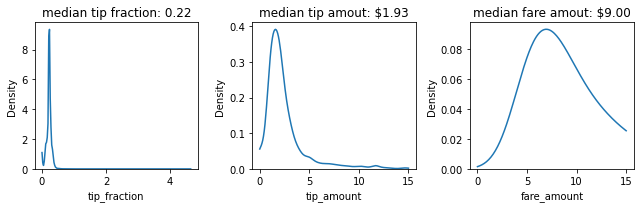

In [13]:
%%px

# Outside Bodo, only work on a single core. Allows interfacing Bodo with anything else.
if bodo.get_rank() == 0:

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    clip = [0, 15]

    sns.kdeplot(data=sample, x="tip_fraction", ax=axs[0], clip=clip)
    axs[0].set_title(f"median tip fraction: {sample['tip_fraction'].median():.2f}")

    sns.kdeplot(data=sample, x="tip_amount", ax=axs[1], clip=clip)
    axs[1].set_title(f"median tip amout: ${sample['tip_amount'].median():.2f}")

    sns.kdeplot(data=sample, x="fare_amount", ax=axs[2], clip=clip)
    axs[2].set_title(f"median fare amout: ${sample['fare_amount'].median():.2f}")

    fig.tight_layout()

We can use the whole dataset with Bodo to compute descriptive statistics.

In [14]:
%%px

@bodo.jit(cache=True)
def tip_fraction_describe(taxi_filtered):
    print(taxi_filtered['tip_fraction'].describe())
    
tip_fraction_describe(taxi_filtered)

%px:   0%|                                                                                                                                                                                                    | 0/4 [00:00<?, ?tasks/s]

[stdout:0] count    5.461173e+06
mean     2.179034e-01
std      1.970128e+00
min      0.000000e+00
25%      1.904762e-01
50%      2.222222e-01
75%      2.494340e-01
max      4.500000e+03
Name: tip_fraction, dtype: float64


%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.31tasks/s]


Even after filtering the data, there are still interesting things to note on the tip fraction. Apparently someone tipped 4500x the fare... 

We often use correlation matrices in machine learning to identify important features. And, in this case, we want to know which features can be used to predict tips.

In [15]:
%%px

@bodo.jit(cache=True)
def correlations(taxi_filtered):
    return taxi_filtered.corr()
    
corr = correlations(taxi_filtered)

%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.28s/tasks]


In [16]:
%%px

if bodo.get_rank() == 0:

    corr_tip_amount = pd.DataFrame(corr["tip_amount"])

    # remove the tip_amount itself from the correlation since it's 1
    # also total_amount is directly computed from the tip_amount
    index = list(corr_tip_amount.index)
    index.remove("tip_amount")
    index.remove("total_amount")
    index.remove("payment_type")
    corr_tip_amount = corr_tip_amount.filter(items=index, axis=0)

    corr_tip_fraction = pd.DataFrame(corr["tip_fraction"])

    # remove the tip_fraction itself from the correlation since it's 1
    index = list(corr_tip_fraction.index)
    index.remove("tip_fraction")
    index.remove("payment_type")
    corr_tip_fraction = corr_tip_fraction.filter(items=index, axis=0)

The correlation matrix by itself is large and since only the tip amount is of interest, there is no need to plot everything.

[output:0]

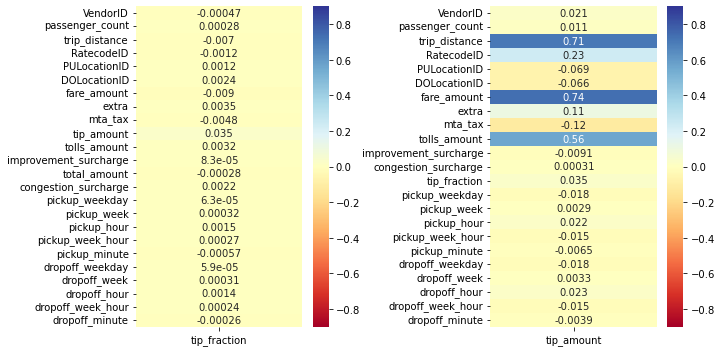

In [17]:
%%px

if bodo.get_rank() == 0:

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(
        corr_tip_fraction,
        annot=True,
        cmap="RdYlBu", center=0,
        vmin=-0.9, vmax=0.9,
        ax=axs[0]
    )

    sns.heatmap(
        corr_tip_amount,
        annot=True,
        cmap="RdYlBu", center=0,
        vmin=-0.9, vmax=0.9,
        ax=axs[1]
    )

    fig.tight_layout()

These correlation plots suggest that the `tip_fraction` is mostly uncorrelated from all the other parameters. The (absolute) `tip_amount` itself is strongly correlated to the `tolls_amount`, `trip_distance` and `fare_amount`.

## Modeling tip amount

Based on the preceding correlation plots, we prepare the dataset by only selecting the `tolls_amount`, `trip_distance` and `fare_amount` as the exogenous variables in our regression model. We extract this new dataset from the filtered taxi dataset using typical column selection. We then split the DataFrame into a training and a testing set with a ratio of $70%/30%$, respectively–which is standard practice in machine learning. 

In [18]:
%%px

@bodo.jit()
def data_preparation(taxi_filtered):

    x_train, x_test, y_train, y_test = train_test_split(
        taxi_filtered[['tolls_amount', 'trip_distance', 'RatecodeID', 'fare_amount']], 
        taxi_filtered['tip_amount'], 
        test_size=0.3,
        train_size=0.7,        
        random_state=42
    )
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = data_preparation(taxi_filtered)

%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25tasks/s]


Next, we train a model and use the test data to evaluate the [RMSE (Root-Mean-Square-Error)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and the [$R^2$ statistic](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) (computed with the functions [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) & [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) respectively, both from [Scikit-Learn's `metrics` submodule](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

In [19]:
%%px

@bodo.jit(cache=True)
def prediction_model(x_train, x_test, y_train, y_test):

    model = LinearRegression()
    # model = RandomForestRegressor(max_depth=50)

    fitted = model.fit(x_train, y_train)
    preds = model.predict(x_test)
    
    print(
        f"RMSE: {mean_squared_error(y_test, preds, squared=False)}\n"
        f"R2: {r2_score(y_test, preds)}\n"
    )
    
    preds = pd.Series(preds, index=y_test.index)
    preds_data = pd.DataFrame({'Pred': preds, 'Test': y_test})

    return preds_data
    
preds_data = prediction_model(x_train, x_test, y_train, y_test)

%px:   0%|                                                                                                                                                                                                    | 0/4 [00:00<?, ?tasks/s]

[stderr:0] /var/folders/5x/5blbwvrs6l5_wct5ncsp5f_m0000gn/T/ipykernel_19261/3934715034.py:20: BodoWarning: Data is distributed so Bodo will fit model with SGD solver optimization (SGDRegressor)
  preds_data = prediction_model(x_train, x_test, y_train, y_test)
/opt/homebrew/Caskroom/mambaforge/base/envs/Bodo/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


%px:   0%|                                                                                                                                                                                                    | 0/4 [00:01<?, ?tasks/s]

[stdout:0] RMSE: 1.846565
R2: 0.497692



[stderr:3] /opt/homebrew/Caskroom/mambaforge/base/envs/Bodo/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


[stderr:1] /opt/homebrew/Caskroom/mambaforge/base/envs/Bodo/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


%px:  50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 2/4 [00:01<00:00, 19.48tasks/s]

[stderr:2] /opt/homebrew/Caskroom/mambaforge/base/envs/Bodo/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


%px: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.73tasks/s]


The RMSE and $R^2$ scores give us a decent first idea of the performance of the model. We can also analyze the density of the output.

In [20]:
%%px

@bodo.jit(cache=True)
def preds_data_sampling(preds_data):
    sample = preds_data.sample(9999)
    return sample

sample = preds_data_sampling(preds_data)

[output:0]

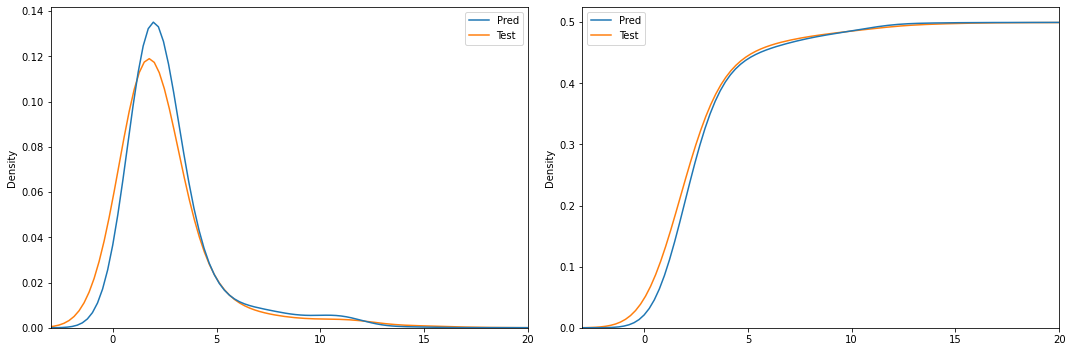

In [21]:
%%px

if bodo.get_rank() == 0:

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].set(xlim=[-3, 20])
    axs[1].set(xlim=[-3, 20])
    
    sns.kdeplot(data=sample, ax=axs[0], bw_adjust=3)
    sns.kdeplot(data=sample, ax=axs[1], bw_adjust=3, cumulative=True)

    fig.tight_layout()

The model is of modest quality but can be useful to provide first estimate.

This concludes this example. Bodo helped us to control and efficiently use the computational resources of our machine. With very little adjustment, we were able to speed up and scale our analysis. Bodo provides an extensive API and supports many well known packages to accommodate for any kind of machine learning pipelines.

You can stop now stop your cluster.

In [ ]:
# To stop the cluster run the following command. 
rc.cluster.stop_cluster_sync()